#CHECKPOINT 4

# **Spark and GraphFrames Set Up**


In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 198 kB 47.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=f5f419772c18871b68e877a3ffc86e717f10de9d312790feade4235f4f2b656c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
     |████████████████████████████████| 154 kB 6.4 MB/s 


Download the graphframes jar file from: [Graphframe jar file:](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)

Upload it in the Google Colab Files folder. Can be found in the left pane of this window.

In [2]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [3]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
import matplotlib.pyplot as plt


In [5]:
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [6]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [7]:
cursor = conn.cursor()

#Action Response Queries


In [8]:
action_response_edges_query = """
DROP TABLE IF EXISTS partners;
CREATE TEMP TABLE partners AS (
    SELECT a.officer_id AS officer_id_a, b.officer_id AS officer_id_b
        FROM data_officerassignmentattendance a, data_officerassignmentattendance b
        WHERE a.start_timestamp = b.start_timestamp AND a.beat_id = b.beat_id
        AND a.present_for_duty AND b.present_for_duty AND a.officer_id <> b.officer_id
            GROUP BY a.officer_id, b.officer_id
            HAVING count(*) > 100

);
DROP TABLE IF EXISTS connected;
CREATE TEMP TABLE connected AS (
WITH filtered_trrs AS (
    SELECT officer_id, event_id, trr_datetime, action_category FROM trr_trr
        JOIN trr_actionresponse ta on trr_trr.id = ta.trr_id
        WHERE cast(action_category as float) >= %(action_response)s
)
,
events AS(
SELECT count(officer_id) AS count, event_id, trr_datetime FROM filtered_trrs
    GROUP BY  event_id, trr_datetime)

,
linked_officer_ids AS (
    SELECT events.event_id, officer_id, count FROM events
        LEFT JOIN trr_trr ON events.event_id = trr_trr.event_id
        WHERE count > 1
)
,
officer_connections AS (
    SELECT A.officer_id AS officer_id1, B.officer_id AS officer_id2, A.event_id AS event_id
        FROM linked_officer_ids A, linked_officer_ids B
        WHERE A.event_id = B.event_id
            AND A.officer_id <> B.officer_id

        ORDER BY officer_id1
)

SELECT officer_id1 as src, officer_id2 as dst,  event_id FROM officer_connections );
SELECT * FROM connected WHERE (src, dst) NOT IN (SELECT * FROM partners)
"""

In [9]:
action_response_vertices_query = """
WITH filtered_trrs AS (
    SELECT officer_id, event_id, action_category FROM trr_trr
        JOIN trr_actionresponse ta on trr_trr.id = ta.trr_id
        WHERE cast(action_category as float) >= %(action_response)s
)
,
events AS(
SELECT count(officer_id) AS count, event_id FROM filtered_trrs
    GROUP BY  event_id)

,
linked_officer_ids AS (
    SELECT events.event_id, officer_id, count FROM events
        LEFT JOIN trr_trr ON events.event_id = trr_trr.event_id
        WHERE count > 1
)
,
linked_officers AS (
    SELECT first_name, middle_initial, last_name, gender, race, trr_count,
           trr_percentile, id FROM data_officer
            JOIN linked_officer_ids ON data_officer.id = linked_officer_ids.officer_id
    )

SELECT * FROM linked_officers


"""

In [10]:
cursor.execute("rollback")

#Partners Graph

In [11]:
cursor.execute(action_response_vertices_query, 
               {'action_response' : 5})
vertices = cursor.fetchall()


df_vertices_ar = pd.DataFrame(vertices)
colnames = [desc[0] for desc in cursor.description]
df_vertices_ar.columns = colnames

df_vertices_ar.drop_duplicates(['id'], keep='first', inplace=True)


In [12]:
cursor.execute(action_response_edges_query, {'action_response' : 5})
edges = cursor.fetchall()

df_edges_ar = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges_ar.columns = colnames

print(df_edges_ar.shape)


(29944, 3)


In [13]:
cursor.execute("SELECT officer_id_a as src, officer_id_b as dst FROM partners")
edges = cursor.fetchall()

df_edges_partners = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges_partners.columns = colnames


In [14]:
cursor.execute("SELECT id, first_name, last_name, race, gender, trr_percentile FROM data_officer")
vertices = cursor.fetchall()
df_vertices_partners = pd.DataFrame(vertices)
colnames = [desc[0] for desc in cursor.description]
df_vertices_partners.columns = colnames

# df_vertices_partners = df_vertices_partners.sample(1000)


In [15]:
df_vertices_partners.shape

(35545, 6)

In [16]:
spark_edges_p = spark.createDataFrame(df_edges_partners)
spark_vertices_p = spark.createDataFrame(df_vertices_partners)
# spark_vertices_p = spark_vertices_p.takeSample(False, 1000)
graph_partners = GraphFrame(spark_vertices_p, spark_edges_p)
graph_partners = graph_partners.dropIsolatedVertices()


In [17]:
spark_vertices_p.show()

+-----+----------+---------+-----+------+--------------------+
|   id|first_name|last_name| race|gender|      trr_percentile|
+-----+----------+---------+-----+------+--------------------+
|32312|   Randall|     Ryan|White|     M|63.00350000000000...|
|32358|     Kevin|    Stoll|White|     M|67.91100000000000...|
|32480|     David|    Lavin|White|     M|               0E-18|
|32491|     Kevin|     Rake|White|     M|               0E-18|
| 2680|   Richard|   Brandt|White|     M|                null|
|29553|      Hugh|Versteegh|White|     M|                null|
|19974|    Andrew|   Murcia|White|     M|                null|
| 8259|      Hugh|   Farmer|White|     M|                null|
|17716|   Anthony|  Matassa|White|     M|                null|
|19659|      John| Moriarty|White|     M|                null|
|32506|   Richard|  Francis|White|     M|               0E-18|
|29111|    Robert|    Tyson|Black|     M|                null|
| 1791|      Chas| Bennette|Black|     M|              

In [18]:
partner_pr = graph_partners.pageRank(tol=0.01)
partner_pr.vertices.sort(['pagerank'], ascending=False).show()

+-----+----------+----------+--------+------+--------------------+------------------+
|   id|first_name| last_name|    race|gender|      trr_percentile|          pagerank|
+-----+----------+----------+--------+------+--------------------+------------------+
|35493|    Andres|   Naranjo|Hispanic|     M|                null|6.3520486820168465|
|35488|  Angelina|     Cahue|Hispanic|     F|                null|6.3520486820168465|
|35474|    George|   Freeman|   Black|     M|                null|2.9286286668165373|
| 8516|      Gary|   Fillipo|   White|     M|               0E-18|2.7685288388728924|
|25864|   Matthew|     Scott|   White|     M|75.20710000000000...| 2.527241533998547|
|25521|     David|   Scafidi|   White|     M|78.27070000000000...|  2.50943978369884|
|15105|    Dennis|  Kounavis|   White|     M|49.10360000000000...| 2.495062723974873|
|28763|     Louis|    Torres|Hispanic|     M|93.47550000000000...|2.4587936178989325|
|31158|         J|   Wombles|   White|     M|38.902800

+----------+---------+--------+------+-----+--------------------+-----+
|first_name|last_name|    race|gender|   id|      trr_percentile|count|
+----------+---------+--------+------+-----+--------------------+-----+
|  Angelina|    Cahue|Hispanic|     F|35488|                null|   71|
|    Andres|  Naranjo|Hispanic|     M|35493|                null|   71|
|    George|  Freeman|   Black|     M|35474|                null|   49|
|   Pauline|    Heard|   Black|     F|11823|38.90280000000000...|   18|
|    Dennis| Kounavis|   White|     M|15105|49.10360000000000...|   18|
|         J|  Wombles|   White|     M|31158|38.90280000000000...|   18|
|    Pamela|    Smith|   Black|     F|26881|               0E-18|   16|
| Alexander|    Verta|   White|     M|35500|                null|   16|
|     Debra|   Howard|   Black|     F|12634|49.10360000000000...|   15|
|  Camillea|    Towns|   Black|     F|35545|                null|   15|
| Alexander| Strockis|   White|     M|35446|                null

(array([5.936e+03, 6.900e+01, 4.000e+01, 1.400e+01, 2.800e+01, 5.000e+00,
        1.000e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0.        ,  2.36666667,  4.73333333,  7.1       ,  9.46666667,
        11.83333333, 14.2       , 16.56666667, 18.93333333, 21.3       ,
        23.66666667, 26.03333333, 28.4       , 30.76666667, 33.13333333,
        35.5       , 37.86666667, 40.23333333, 42.6       , 44.96666667,
        47.33333333, 49.7       , 52.06666667, 54.43333333, 56.8       ,
        59.16666667, 61.53333333, 63.9       , 66.26666667, 68.63333333,
        71.        ]),
 <a list of 30 Patch objects>)

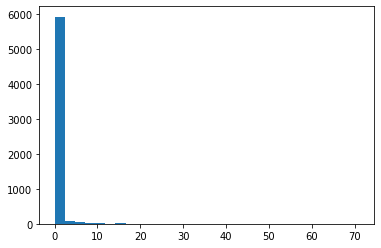

In [19]:
partner_tc = graph_partners.triangleCount()
partner_tc.sort(["count"], ascending=False).select("first_name", "last_name","race", "gender", "id", "trr_percentile", "count").show(30)
bins, counts = partner_tc.select('count').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)


###Action Response Graph Generation

In [20]:
spark_edges_ar = spark.createDataFrame(df_edges_ar)
spark_vertices_ar = spark.createDataFrame(df_vertices_ar)

In [21]:
graph_trr_ar = GraphFrame(spark_vertices_ar, spark_edges_ar)

In [22]:
trr_ar_pr = graph_trr_ar.pageRank(tol=0.01)
trr_ar_pr.vertices.sort(['pagerank'], ascending=False).show()

+----------+--------------+-----------+------+--------------------+---------+--------------------+-----+------------------+
|first_name|middle_initial|  last_name|gender|                race|trr_count|      trr_percentile|   id|          pagerank|
+----------+--------------+-----------+------+--------------------+---------+--------------------+-----+------------------+
|    Angelo|          null|    Mandile|     M|               White|       19|97.07820000000000...|17189| 7.088693789238327|
|     Chris|          null|Skarupinski|     M|               White|       26|98.97880000000000...|26540| 6.514403831607933|
|    George|             A|    Granias|     M|Native American/A...|       72|99.96030000000000...|10583| 5.945596545668317|
| Evangelos|          null|    Hitiris|     M|               White|       41|99.21710000000000...|12299| 5.416864128845634|
|   Gerardo|          null|       Vega|     M|            Hispanic|       27|98.59870000000000...|29454| 5.173808348274441|
|   Phil

In [23]:
highest_pr_trrs = trr_ar_pr.vertices.sort(['pagerank'], ascending=False).limit(1000)

In [24]:
highest_pr_trrs = highest_pr_trrs.toPandas()
highest_pr_trrs.columns = ["first_name", "mi", "last_name", "gender", "race", "trr_count", "trr_percentile","id", "page_rank"]

In [25]:
ids = highest_pr_trrs['id']
# print(ids)
associated_partner_page_rank = []
partner_pr_pd = partner_pr.vertices.toPandas()
# print(partner_pr_pd)
for id in ids:
  row = partner_pr_pd.loc[partner_pr_pd["id"] == id]
  if not row.empty:
    associated_partner_page_rank.append(row['pagerank'].tolist()[0])
    # print(row['pagerank'].tolist()[0])
  else:
    associated_partner_page_rank.append(None)

# print(associated_partner_page_rank)
highest_pr_trrs['partner_page_rank'] = associated_partner_page_rank
# print(highest_pr_trrs)

In [26]:
highest_pr_trrs.head(20)

,first_name,mi,last_name,gender,race,trr_count,trr_percentile,id,page_rank,partner_page_rank
0,Angelo,None,Mandile,M,White,19,97.078200000000000000,17189,7.088694,1.013898
1,Chris,None,Skarupinski,M,White,26,98.978800000000000000,26540,6.514404,NaN
2,George,A,Granias,M,Native American/Alaskan Native,72,99.960300000000000000,10583,5.945597,NaN
3,Evangelos,None,Hitiris,M,White,41,99.217100000000000000,12299,5.416864,NaN
4,Gerardo,None,Vega,M,Hispanic,27,98.598700000000000000,29454,5.173808,1.566724
5,Phillip,E,Orlando,M,Hispanic,41,99.217100000000000000,21371,4.833944,NaN
6,Nicholas,G,Harris,M,White,14,93.935100000000000000,11511,4.819227,NaN
7,Vincent,P,Baldassano,M,White,21,94.871200000000000000,31815,4.793859,NaN
8,Christoph,M,Saladino,M,Hispanic,26,96.845600000000000000,25155,4.666504,0.654806
9,Nellie,None,Harb,F,Hispanic,22,95.381800000000000000,11384,4.612397,NaN


+----------+----------+--------+------+-----+--------------------+-----+
|first_name| last_name|    race|gender|   id|      trr_percentile|count|
+----------+----------+--------+------+-----+--------------------+-----+
|   Phillip|   Orlando|Hispanic|     M|21371|99.21710000000000...|  157|
|     James|      Wynn|   White|     M|31337|93.66280000000000...|  130|
|      Ryan|     Harty|   White|     M|11615|95.38180000000000...|  113|
|     Steve|    Jarosz|   White|     M|13313|96.06260000000000...|  111|
|     Wayne|    Wiberg|   White|     M|30561|97.83840000000000...|  102|
|    Robert|  Mccallum|   White|     M|32175|96.84560000000000...|  102|
|      Mark|  O Connor|   White|     M|20860|72.10940000000000...|   97|
|   Jeffrey|    Felton|   White|     M| 8349|67.91100000000000...|   94|
|     Kevin|   Connors|   White|     M| 5204|72.10940000000000...|   93|
|     Glenn|     Evans|   Black|     M| 8138|94.87120000000000...|   93|
|   Richard|  Antonsen|   White|     M|  761|86.684

(array([3.564e+03, 6.530e+02, 1.690e+02, 1.170e+02, 6.400e+01, 4.500e+01,
        5.600e+01, 8.000e+00, 1.900e+01, 1.100e+01, 2.900e+01, 5.000e+00,
        1.000e+01, 8.000e+00, 1.000e+00, 5.000e+00, 0.000e+00, 1.000e+01,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,   5.23333333,  10.46666667,  15.7       ,
         20.93333333,  26.16666667,  31.4       ,  36.63333333,
         41.86666667,  47.1       ,  52.33333333,  57.56666667,
         62.8       ,  68.03333333,  73.26666667,  78.5       ,
         83.73333333,  88.96666667,  94.2       ,  99.43333333,
        104.66666667, 109.9       , 115.13333333, 120.36666667,
        125.6       , 130.83333333, 136.06666667, 141.3       ,
        146.53333333, 151.76666667, 157.        ]),
 <a list of 30 Patch objects>)

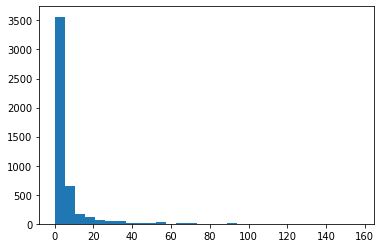

In [27]:
trr_ar_tc = graph_trr_ar.triangleCount()
trr_ar_tc.sort(["count"], ascending=False).select("first_name", "last_name","race", "gender", "id", "trr_percentile", "count").show(30)
bins, counts = trr_ar_tc.select('count').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)

#Use of Force Queries


In [28]:
force_edges_query = """
with officer_allegation_filter as (
    select id,category from data_allegationcategory)
    --where category = 'Use Of Force' )




, joined_officer_allegation_filter as (
select t2.id, officer_id, category, allegation_id from officer_allegation_filter t1
    join  data_officerallegation t2 on t1.id = t2.allegation_category_id)
, count_alleg



    as (
select  allegation_id,   count(officer_id) as count from joined_officer_allegation_filter
where category = 'Use Of Force'

    group by allegation_id
    having count(officer_id) > 1
    order by count)
,
     linked_allegations as (select
          t1.allegation_id, count, officer_id from count_alleg t1
         left join  joined_officer_allegation_filter t2 on   t1.allegation_id = t2.allegation_id
         ),

   officer_connections AS (
    SELECT A.officer_id AS officer_id1, B.officer_id AS officer_id2, A.allegation_id AS allegation_id
        FROM linked_allegations A, linked_allegations B
        WHERE A.allegation_id = B.allegation_id
            AND A.officer_id <> B.officer_id
        ORDER BY officer_id1
)
select officer_id1 AS src, officer_id2 AS dst, allegation_id from  officer_connections

"""

In [29]:
force_vertices_query = """

with officer_allegation_filter as (
    select id,category from data_allegationcategory)
    --where category = 'Use Of Force' )

, joined_officer_allegation_filter as (
select t2.id, officer_id, category, allegation_id from officer_allegation_filter t1
    join  data_officerallegation t2 on t1.id = t2.allegation_category_id)
, count_alleg

    as (
select  allegation_id,   count(officer_id) as count from joined_officer_allegation_filter
where category = 'Use Of Force'

    group by allegation_id
    having count(officer_id) > 1
    order by count)
,
     linked_allegations as (select
          t1.allegation_id, count, officer_id from count_alleg t1
         left join  joined_officer_allegation_filter t2 on   t1.allegation_id = t2.allegation_id
         ),

linked_allegation_race as  (

    select * from   linked_allegations join (select race, id from data_officer) as t1
    on linked_allegations.officer_id  = t1.id
)

select allegation_id, race, id from linked_allegation_race

"""

In [30]:
cursor.execute(force_edges_query)
edges = cursor.fetchall()

df_edges_f = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges_f.columns = colnames

In [31]:
cursor.execute(force_vertices_query)
vertices = cursor.fetchall()


df_vertices_f = pd.DataFrame(vertices)
colnames = [desc[0] for desc in cursor.description]
df_vertices_f.columns = colnames

df_vertices_f.drop_duplicates(['id'], keep='first', inplace=True)

In [32]:
spark_edges_f = spark.createDataFrame(df_edges_f)
spark_vertices_f = spark.createDataFrame(df_vertices_f)
graph_force = GraphFrame(spark_vertices_f, spark_edges_f)

In [33]:
f_pr = graph_force.pageRank(tol=0.01)
highest_f_pr = f_pr.vertices.sort(['pagerank'], ascending=False).limit(1000)
highest_f_pr = highest_f_pr.toPandas()

ids = highest_f_pr['id']
# print(ids)
associated_partner_page_rank = []
partner_pr_pd = partner_pr.vertices.toPandas()
# print(partner_pr_pd)
for id in ids:
  row = partner_pr_pd.loc[partner_pr_pd["id"] == id]
  if not row.empty:
    associated_partner_page_rank.append(row['pagerank'].tolist()[0])
    # print(row['pagerank'].tolist()[0])
  else:
    associated_partner_page_rank.append(None)

# print(associated_partner_page_rank)
highest_f_pr['partner_page_rank'] = associated_partner_page_rank

In [34]:
highest_f_pr.head(20)

,allegation_id,race,id,pagerank,partner_page_rank
0,1006219,Black,8138,9.340602,NaN
1,1024627,White,17816,7.564095,NaN
2,1013586,Hispanic,25306,7.011603,NaN
3,1005133,White,2375,6.942383,NaN
4,1042613,White,2356,6.330553,NaN
5,1011304,White,3277,6.053319,NaN
6,C217232,White,29033,5.728800,1.013898
7,C141303,White,27392,5.694141,NaN
8,C171608,White,8562,5.467520,NaN
9,C181200,Hispanic,4212,5.437083,NaN


+-----+-----+
|   id|count|
+-----+-----+
|30337| 1363|
|31536| 1340|
| 2375| 1229|
| 2356| 1217|
|21364| 1215|
|25230| 1197|
| 9648| 1189|
| 4226| 1182|
| 1832| 1147|
| 4565| 1146|
|20616| 1143|
|32072| 1141|
|32390| 1140|
| 6704| 1140|
|27668| 1136|
|12947| 1136|
|25983| 1135|
|28601| 1134|
| 1739| 1131|
|13093| 1131|
|29252| 1131|
| 4254| 1131|
|28384| 1131|
|28178| 1131|
|  560| 1130|
| 1517| 1130|
| 7032| 1129|
|24063| 1129|
|14710| 1129|
|19798| 1128|
+-----+-----+
only showing top 30 rows



(array([1.2362e+04, 6.3400e+02, 2.1200e+02, 6.8000e+01, 3.2000e+01,
        4.8000e+01, 3.0000e+00, 1.8000e+01, 1.4000e+01, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3000e+01,
        8.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([   0.        ,   45.43333333,   90.86666667,  136.3       ,
         181.73333333,  227.16666667,  272.6       ,  318.03333333,
         363.46666667,  408.9       ,  454.33333333,  499.76666667,
         545.2       ,  590.63333333,  636.06666667,  681.5       ,
         726.93333333,  772.36666667,  817.8       ,  863.23333333,
         908.66666667,  954.1       ,  999.53333333, 1044.96666667,
        1090.4       , 1135.83333333, 1181.26666667, 1226.7       ,
        1272.13333333, 1317.56666667, 1363.        ]),
 <a list of 30 Patch objects>)

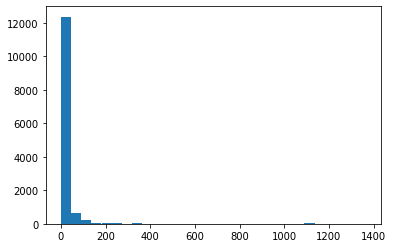

In [35]:
trr_f_tc = graph_force.triangleCount()
trr_f_tc.sort(["count"], ascending=False).select("id", "count").show(30)
bins, counts = trr_f_tc.select('count').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)

# Graph Functions

In [36]:


def plot_graph_no_color(gx, size_px, dpi, output_name):
    g = nx.DiGraph(directed = False)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])
    fig = plt.figure(1, figsize=(size_px, size_px), dpi=dpi)
    race_map = {'White' : 'blue',
                'Black' : 'orange',
                'Asian/Pacific' : 'green',
                'Native American/Alaskan Native' : 'black',
                'Hispanic' : 'yellow',
                'Other' : 'purple'}
    
    print(g.nodes())
    races = [race_map.get(gx.vertices.filter(gx.vertices['id'] == node).select('race').collect()[0][0]) for node in g.nodes()]
    nx.draw(g, with_labels=True, arrows = False, node_color=races, edge_color='black', font_color='purple')
    plt.savefig(output_name, dpi=dpi, bbox_inches='tight')

   

In [37]:
# NetworkX to visualize the graph
import networkx as nx

def plot_graph(gx, size_px, dpi, output_name):
    g = nx.DiGraph(directed = False)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])
    fig = plt.figure(1, figsize=(size_px, size_px), dpi=dpi)

    race_map = {'White' : 'blue',
                'Black' : 'orange',
                'Asian/Pacific' : 'green',
                'Native American/Alaskan Native' : 'black',
                'Hispanic' : 'yellow',
                'Other' : 'purple'}
    
    print(g.nodes())
    races = [race_map.get(gx.vertices.filter(gx.vertices['id'] == node).select('race').collect()[0][0]) for node in g.nodes()]
    nx.draw(g, with_labels=True, arrows = False, node_color=races, edge_color='black', font_color='purple')
    plt.savefig(output_name, dpi=dpi, bbox_inches='tight')

    print(races)
    

#Graph Visualization

In [38]:
#plot_graph(graph_trr_ar, 17, 30, '5_action_response.png')

In [ ]:
plot_graph(graph_force, 150, 40, 'use of force.png')

[1, 16856, 800, 2, 30197, 7946, 9271, 18532, 10733, 6, 15932, 12623, 20866, 9523, 28668, 13958, 27284, 19914, 7, 22269, 11, 27663, 12, 25623, 9751, 11524, 13, 17913, 29880, 16, 13937, 13021, 30460, 4668, 5423, 16551, 25799, 17, 32102, 28925, 15351, 18, 23168, 6898, 20, 11671, 33, 8849, 10184, 10966, 20850, 27872, 14794, 14179, 26464, 34, 24298, 26496, 30049, 14638, 23520, 38, 31194, 6514, 25577, 5284, 39, 14710, 15004, 213, 3776, 41, 21351, 8103, 19264, 1248, 28162, 42, 12449, 14814, 26516, 14955, 27673, 15695, 7595, 21517, 31540, 44, 25299, 15407, 3243, 4405, 1345, 29255, 6845, 31550, 27088, 31864, 21145, 48, 6563, 6664, 8652, 49, 23424, 10317, 13894, 51, 64, 20827, 20125, 52, 16071, 11073, 54, 29189, 56, 18536, 12935, 58, 9997, 3189, 15051, 7402, 5382, 15474, 17862, 3482, 9576, 25373, 12967, 26828, 18473, 1775, 8564, 20757, 24431, 17587, 59, 31366, 10952, 26385, 8071, 24433, 60, 12497, 32052, 10542, 11689, 31946, 442, 29432, 17711, 21286, 21316, 4544, 9473, 25442, 26692, 24026, 21220

In [ ]:
#plot_graph(graph_partners, 15, 8, "partners.png")